In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam

In [2]:
path = "D:\BaiduNetdiskDownload\data\donghai\\2011-2014.nc"
dataset = xr.open_dataset(path)

In [3]:
# 目标D经纬度坐标
target_longitude = 124.00
target_latitude = 31.00

In [4]:
# 固定经度和纬度并获取其余信息
subset_data = dataset.sel(longitude=target_longitude, latitude=target_latitude, method='nearest')

In [5]:
time = subset_data.variables['time'][:].data
u10 = subset_data.variables['u10'][:].data
v10 = subset_data.variables['v10'][:].data
swh = subset_data.variables['swh'][:].data
print(swh[0])

4.016243


In [6]:
# 创建DataFrame来组织数据
data = pd.DataFrame({'time': time, 'u10': u10, 'v10': v10, 'swh': swh})

In [7]:
X = data[['u10', 'v10', 'swh']].values
y = data['swh'].values
y = np.roll(y,shift=-3)


In [8]:
# 划分数据集为训练集和测试集
split_point = int(0.8 * len(X))
X_train = X[:split_point]
X_test = X[split_point:]
y_train = y[:split_point]
y_test = y[split_point:]
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 标准化特征
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
# 将数据转换为PyTorch张量
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [10]:
# 创建PyTorch数据集和数据加载器
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [11]:
# 定义GRU模型
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])  # 取最后一个时间步的输出
        return out



In [12]:
# 创建GRU模型实例
input_size = 3  # 输入特征数量（u10和v10）
hidden_size = 50
model = GRUModel(input_size, hidden_size)

In [13]:
# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [14]:
# 训练模型
num_epochs = 10
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs.unsqueeze(1))
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 0.0733
Epoch [2/10], Loss: 0.0127
Epoch [3/10], Loss: 0.0133
Epoch [4/10], Loss: 0.0502
Epoch [5/10], Loss: 0.0223
Epoch [6/10], Loss: 0.0177
Epoch [7/10], Loss: 0.0160
Epoch [8/10], Loss: 0.0222
Epoch [9/10], Loss: 0.0234
Epoch [10/10], Loss: 0.0197


In [15]:
# 测试模型
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor.unsqueeze(1))
    test_loss = criterion(y_pred_tensor, y_test_tensor.unsqueeze(1))

print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 0.0401


In [16]:
# 将PyTorch张量转换回NumPy数组
y_pred = y_pred_tensor.numpy()
y_test = y_test_tensor.numpy()


In [17]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

from scipy.stats import pearsonr
r, _ = pearsonr(y_test, y_pred)
print("Correlation coefficient (R):", r)

RMSE: 0.20019141402751917
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Correlation coefficient (R): [0.9884437002414985]


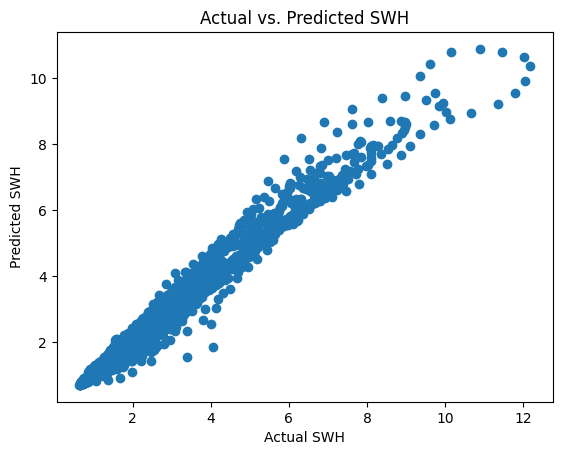

In [18]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.xlabel("Actual SWH")
plt.ylabel("Predicted SWH")
plt.title("Actual vs. Predicted SWH")
plt.show()

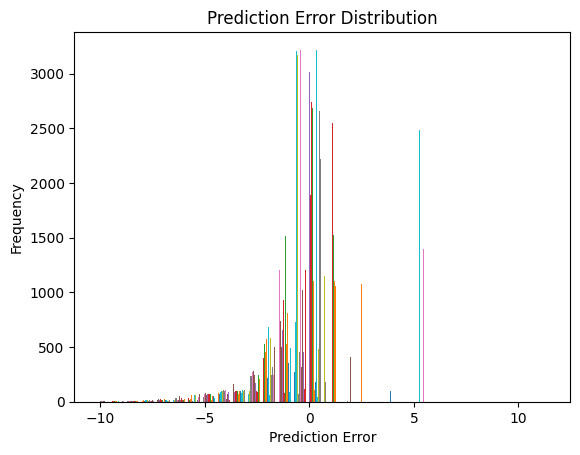

In [19]:
errors = y_test - y_pred
plt.hist(errors, bins=30)
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Prediction Error Distribution")
plt.show()